# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-14f285da-93ee-ebf8-f195-e154a3c5de68)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:12<00:00, 13148036.18it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
##########################################
#############    Model_1~4   #############
##########################################
model_1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights= None)            # 有4種情況 18*none, 18*v1, 50*none, 50*v1
model_2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='IMAGENET1K_V1')
model_3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights= None)
model_4 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='IMAGENET1K_V1')

model_1.fc = torch.nn.Linear(model_1.fc.in_features, 10)
model_2.fc = torch.nn.Linear(model_2.fc.in_features, 10)
model_3.fc = torch.nn.Linear(model_3.fc.in_features, 10)
model_4.fc = torch.nn.Linear(model_4.fc.in_features, 10)

print('done')



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


done


### Training and Testing Models

In [ ]:
#=====================================================================
#                       Training model def 
#=====================================================================

##########################################
##########    loss & optimizer  ##########
##########################################
loss_fn = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=1e-3)

##########################################
##############    Model_1   ##############
##########################################
def train_1(dataloader, model_1, loss_fn, optimizer_1):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_1.train()

  for X, Y in tqdm(dataloader):   
    # X, Y = X.to(device), Y.to(device)

    # Compute prediction error
    pred = model_1(X)
    loss = loss_fn(pred, Y)

    # Backpropagation
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

    epoch_loss += loss.item()
    pred = pred.argmax(dim = 1, keepdim = True)
    correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

def test_1(dataloader, model_1, loss_fn):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_1.eval()

  with torch.no_grad():
    for X, Y in tqdm(dataloader):
      # X, Y = X.to(device), Y.to(device)

      pred = model_1(X)

      epoch_loss += loss_fn(pred, Y).item()
      pred = pred.argmax(dim = 1, keepdim = True)
      correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

##########################################
##############    Model_2   ##############
##########################################
def train_2(dataloader, model_2, loss_fn, optimizer_2):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_2.train()

  for X, Y in tqdm(dataloader):   
    # X, Y = X.to(device), Y.to(device)

    # Compute prediction error
    pred = model_2(X)
    loss = loss_fn(pred, Y)

    # Backpropagation
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()

    epoch_loss += loss.item()
    pred = pred.argmax(dim = 1, keepdim = True)
    correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

def test_2(dataloader, model_2, loss_fn):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_2.eval()

  with torch.no_grad():
    for X, Y in tqdm(dataloader):
      # X, Y = X.to(device), Y.to(device)

      pred = model_2(X)

      epoch_loss += loss_fn(pred, Y).item()
      pred = pred.argmax(dim = 1, keepdim = True)
      correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

##########################################
##############    Model_3   ##############
##########################################
def train_3(dataloader, model_3, loss_fn, optimizer_3):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_3.train()

  for X, Y in tqdm(dataloader):   
    # X, Y = X.to(device), Y.to(device)

    # Compute prediction error
    pred = model_3(X)
    loss = loss_fn(pred, Y)

    # Backpropagation
    optimizer_3.zero_grad()
    loss.backward()
    optimizer_3.step()

    epoch_loss += loss.item()
    pred = pred.argmax(dim = 1, keepdim = True)
    correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

def test_3(dataloader, model_3, loss_fn):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_3.eval()

  with torch.no_grad():
    for X, Y in tqdm(dataloader):
      # X, Y = X.to(device), Y.to(device)

      pred = model_3(X)

      epoch_loss += loss_fn(pred, Y).item()
      pred = pred.argmax(dim = 1, keepdim = True)
      correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc
##########################################
##############    Model_4   ##############
##########################################
def train_4(dataloader, model_4, loss_fn, optimizer_4):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_4.train()

  for X, Y in tqdm(dataloader):   
    # X, Y = X.to(device), Y.to(device)

    # Compute prediction error
    pred = model_4(X)
    loss = loss_fn(pred, Y)

    # Backpropagation
    optimizer_4.zero_grad()
    loss.backward()
    optimizer_4.step()

    epoch_loss += loss.item()
    pred = pred.argmax(dim = 1, keepdim = True)
    correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

def test_4(dataloader, model_4, loss_fn):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  epoch_loss = 0
  correct = 0

  model_4.eval()

  with torch.no_grad():
    for X, Y in tqdm(dataloader):
      # X, Y = X.to(device), Y.to(device)

      pred = model_4(X)

      epoch_loss += loss_fn(pred, Y).item()
      pred = pred.argmax(dim = 1, keepdim = True)
      correct += pred.eq(Y.view_as(pred)).sum().item()

  avg_epoch_loss = epoch_loss / num_batches
  avg_acc = correct / size
  return avg_epoch_loss, avg_acc

In [ ]:
#=====================================================================
#                              Training 
#=====================================================================
epochs = 5

print("==========Adam==========\n")

##########################################
##############    Model_1   ##############
##########################################
print("==========model_1==========\n")

print("==========sixteenth_train_dataloader==========\n")
acc_sixteenth_list_1 = []
acc_test_sixteenth_list_1 = []
for epoch in range(epochs):
  train_loss, train_acc = train_1(sixteenth_train_dataloader, model_1, loss_fn, optimizer_1)
  test_loss, test_acc = test_1(valid_dataloader, model_1, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_sixteenth_list_1.append(train_acc)
  acc_test_sixteenth_list_1.append(test_acc)
print("Done!")

print("==========half_train_dataloader==========\n")
acc_half_list_1 = []
acc_test_half_list_1 = []
for epoch in range(epochs):
  train_loss, train_acc = train_1(half_train_dataloader, model_1, loss_fn, optimizer_1)
  test_loss, test_acc = test_1(valid_dataloader, model_1, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_half_list_1.append(train_acc)
  acc_test_half_list_1.append(test_acc)
print("Done!")

print("==========train_dataloader==========\n")
acc_all_list_1 = []
acc_test_all_list_1 = []
for epoch in range(epochs):
  train_loss, train_acc = train_1(train_dataloader, model_1, loss_fn, optimizer_1)
  test_loss, test_acc = test_1(valid_dataloader, model_1, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_all_list_1.append(train_acc)
  acc_test_all_list_1.append(test_acc)
print("Done!")

##########################################
##############    Model_2   ##############
##########################################
print("==========model_2==========\n")

print("==========sixteenth_train_dataloader==========\n")
acc_sixteenth_list_2 = []
acc_test_sixteenth_list_2 = []
for epoch in range(epochs):
  train_loss, train_acc = train_2(sixteenth_train_dataloader, model_2, loss_fn, optimizer_2)
  test_loss, test_acc = test_2(valid_dataloader, model_2, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_sixteenth_list_2.append(train_acc)
  acc_test_sixteenth_list_2.append(test_acc)
print("Done!")

print("==========half_train_dataloader==========\n")
acc_half_list_2 = []
acc_test_half_list_2 = []
for epoch in range(epochs):
  train_loss, train_acc = train_2(half_train_dataloader, model_2, loss_fn, optimizer_2)
  test_loss, test_acc = test_2(valid_dataloader, model_2, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_half_list_2.append(train_acc)
  acc_test_half_list_2.append(test_acc)
print("Done!")

print("==========train_dataloader==========\n")
acc_all_list_2 = []
acc_test_all_list_2 = []
for epoch in range(epochs):
  train_loss, train_acc = train_2(train_dataloader, model_2, loss_fn, optimizer_2)
  test_loss, test_acc = test_2(valid_dataloader, model_2, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_all_list_2.append(train_acc)
  acc_test_all_list_2.append(test_acc)
print("Done!")

##########################################
##############    Model_3   ##############
##########################################
print("==========model_3==========\n")

print("==========sixteenth_train_dataloader==========\n")
acc_sixteenth_list_3 = []
acc_test_sixteenth_list_3 = []
for epoch in range(epochs):
  train_loss, train_acc = train_3(sixteenth_train_dataloader, model_3, loss_fn, optimizer_3)
  test_loss, test_acc = test_3(valid_dataloader, model_3, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_sixteenth_list_3.append(train_acc)
  acc_test_sixteenth_list_3.append(test_acc)
print("Done!")

print("==========half_train_dataloader==========\n")
acc_half_list_3 = []
acc_test_half_list_3 = []
for epoch in range(epochs):
  train_loss, train_acc = train_3(half_train_dataloader, model_3, loss_fn, optimizer_3)
  test_loss, test_acc = test_3(valid_dataloader, model_3, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_half_list_3.append(train_acc)
  acc_test_half_list_3.append(test_acc)
print("Done!")

print("==========train_dataloader==========\n")
acc_all_list_3 = []
acc_test_all_list_3 = []
for epoch in range(epochs):
  train_loss, train_acc = train_3(train_dataloader, model_3, loss_fn, optimizer_3)
  test_loss, test_acc = test_3(valid_dataloader, model_3, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_all_list_3.append(train_acc)
  acc_test_all_list_3.append(test_acc)
print("Done!")

##########################################
##############    Model_4   ##############
##########################################

print("==========model_4==========\n")

print("==========sixteenth_train_dataloader==========\n")
acc_sixteenth_list_4 = []
acc_test_sixteenth_list_4 = []
for epoch in range(epochs):
  train_loss, train_acc = train_4(sixteenth_train_dataloader, model_4, loss_fn, optimizer_4)
  test_loss, test_acc = test_4(valid_dataloader, model_4, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_sixteenth_list_4.append(train_acc)
  acc_test_sixteenth_list_4.append(test_acc)
print("Done!")

print("==========half_train_dataloader==========\n")
acc_half_list_4 = []
acc_test_half_list_4 = []
for epoch in range(epochs):
  train_loss, train_acc = train_4(half_train_dataloader, model_4, loss_fn, optimizer_4)
  test_loss, test_acc = test_4(valid_dataloader, model_4, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_half_list_4.append(train_acc)
  acc_test_half_list_4.append(test_acc)
print("Done!")

print("==========train_dataloader==========\n")
acc_all_list_4 = []
acc_test_all_list_4 = []
for epoch in range(epochs):
  train_loss, train_acc = train_4(train_dataloader, model_4, loss_fn, optimizer_4)
  test_loss, test_acc = test_4(valid_dataloader, model_4, loss_fn)
  print(f"Epoch {epoch+1:2d}:Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
  acc_all_list_4.append(train_acc)
  acc_test_all_list_4.append(test_acc)
print("Done!")


==========Adam==========

==========model_1==========

==========sixteenth_train_dataloader==========



100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


Epoch  1:Loss = 2.1476 Acc = 0.02 Test_Loss = 2.2104 Test_Acc = 0.19


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch  2:Loss = 1.9254 Acc = 0.02 Test_Loss = 2.4530 Test_Acc = 0.27


100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch  3:Loss = 1.7895 Acc = 0.02 Test_Loss = 1.6900 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch  4:Loss = 1.6628 Acc = 0.02 Test_Loss = 1.6550 Test_Acc = 0.39


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Epoch  5:Loss = 1.6442 Acc = 0.02 Test_Loss = 1.6073 Test_Acc = 0.40
Done!
==========half_train_dataloader==========



100%|██████████| 40/40 [00:04<00:00,  8.77it/s]


Epoch  1:Loss = 1.4727 Acc = 0.23 Test_Loss = 1.3647 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Epoch  2:Loss = 1.3138 Acc = 0.26 Test_Loss = 1.2090 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch  3:Loss = 1.1734 Acc = 0.29 Test_Loss = 1.1495 Test_Acc = 0.58


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch  4:Loss = 1.0927 Acc = 0.30 Test_Loss = 1.0737 Test_Acc = 0.62


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch  5:Loss = 1.0284 Acc = 0.32 Test_Loss = 1.1848 Test_Acc = 0.60
Done!
==========train_dataloader==========



100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch  1:Loss = 0.9567 Acc = 0.66 Test_Loss = 0.8889 Test_Acc = 0.69


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch  2:Loss = 0.8718 Acc = 0.69 Test_Loss = 0.8235 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Epoch  3:Loss = 0.8207 Acc = 0.71 Test_Loss = 0.8278 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


Epoch  4:Loss = 0.7711 Acc = 0.73 Test_Loss = 0.8163 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Epoch  5:Loss = 0.7285 Acc = 0.74 Test_Loss = 0.7340 Test_Acc = 0.74
Done!
==========model_2==========

==========sixteenth_train_dataloader==========



100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


Epoch  1:Loss = 1.9112 Acc = 0.02 Test_Loss = 2.0604 Test_Acc = 0.40


100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Epoch  2:Loss = 1.4164 Acc = 0.03 Test_Loss = 1.4847 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch  3:Loss = 1.2531 Acc = 0.04 Test_Loss = 1.3728 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Epoch  4:Loss = 1.1466 Acc = 0.04 Test_Loss = 1.3930 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Epoch  5:Loss = 1.0469 Acc = 0.04 Test_Loss = 1.0434 Test_Acc = 0.64
Done!
==========half_train_dataloader==========



100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch  1:Loss = 0.8949 Acc = 0.35 Test_Loss = 0.8260 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Epoch  2:Loss = 0.7405 Acc = 0.37 Test_Loss = 0.8702 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch  3:Loss = 0.6913 Acc = 0.38 Test_Loss = 0.6901 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch  4:Loss = 0.6328 Acc = 0.39 Test_Loss = 0.6746 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Epoch  5:Loss = 0.5959 Acc = 0.40 Test_Loss = 0.6241 Test_Acc = 0.79
Done!
==========train_dataloader==========



100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Epoch  1:Loss = 0.5678 Acc = 0.81 Test_Loss = 0.6114 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.87it/s]


Epoch  2:Loss = 0.5277 Acc = 0.82 Test_Loss = 0.6739 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch  3:Loss = 0.4903 Acc = 0.83 Test_Loss = 0.5922 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch  4:Loss = 0.4666 Acc = 0.84 Test_Loss = 0.5617 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch  5:Loss = 0.4430 Acc = 0.85 Test_Loss = 0.5397 Test_Acc = 0.82
Done!
==========model_3==========

==========sixteenth_train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


Epoch  1:Loss = 2.8531 Acc = 0.01 Test_Loss = 2.3809 Test_Acc = 0.11


100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


Epoch  2:Loss = 2.3735 Acc = 0.01 Test_Loss = 2.1382 Test_Acc = 0.18


100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


Epoch  3:Loss = 2.1039 Acc = 0.02 Test_Loss = 1.9496 Test_Acc = 0.27


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


Epoch  4:Loss = 2.0923 Acc = 0.02 Test_Loss = 1.9196 Test_Acc = 0.29


100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Epoch  5:Loss = 1.9655 Acc = 0.02 Test_Loss = 1.8475 Test_Acc = 0.32
Done!
==========half_train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


Epoch  1:Loss = 1.8089 Acc = 0.18 Test_Loss = 1.5872 Test_Acc = 0.41


100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


Epoch  2:Loss = 1.6364 Acc = 0.21 Test_Loss = 4.4134 Test_Acc = 0.43


100%|██████████| 40/40 [00:09<00:00,  4.10it/s]


Epoch  3:Loss = 1.5839 Acc = 0.22 Test_Loss = 5.4166 Test_Acc = 0.45


100%|██████████| 40/40 [00:09<00:00,  4.22it/s]


Epoch  4:Loss = 1.5257 Acc = 0.23 Test_Loss = 12.3747 Test_Acc = 0.36


100%|██████████| 40/40 [00:09<00:00,  4.18it/s]


Epoch  5:Loss = 1.7516 Acc = 0.20 Test_Loss = 1.5808 Test_Acc = 0.42
Done!
==========train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


Epoch  1:Loss = 1.5916 Acc = 0.44 Test_Loss = 1.4180 Test_Acc = 0.49


100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Epoch  2:Loss = 1.6318 Acc = 0.42 Test_Loss = 1.6026 Test_Acc = 0.41


100%|██████████| 40/40 [00:09<00:00,  4.34it/s]


Epoch  3:Loss = 1.5985 Acc = 0.43 Test_Loss = 1.4417 Test_Acc = 0.47


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


Epoch  4:Loss = 1.4871 Acc = 0.47 Test_Loss = 1.2941 Test_Acc = 0.52


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


Epoch  5:Loss = 1.3854 Acc = 0.51 Test_Loss = 1.3050 Test_Acc = 0.53
Done!
==========model_4==========

==========sixteenth_train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


Epoch  1:Loss = 1.9672 Acc = 0.02 Test_Loss = 5.0815 Test_Acc = 0.24


100%|██████████| 40/40 [00:09<00:00,  4.18it/s]


Epoch  2:Loss = 1.3572 Acc = 0.03 Test_Loss = 4.4669 Test_Acc = 0.46


100%|██████████| 40/40 [00:09<00:00,  4.17it/s]


Epoch  3:Loss = 1.1853 Acc = 0.04 Test_Loss = 2.5890 Test_Acc = 0.52


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


Epoch  4:Loss = 1.0990 Acc = 0.04 Test_Loss = 1.0292 Test_Acc = 0.65


100%|██████████| 40/40 [00:09<00:00,  4.17it/s]


Epoch  5:Loss = 1.0114 Acc = 0.04 Test_Loss = 1.0275 Test_Acc = 0.66
Done!
==========half_train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


Epoch  1:Loss = 0.8559 Acc = 0.35 Test_Loss = 0.8118 Test_Acc = 0.73


100%|██████████| 40/40 [00:09<00:00,  4.14it/s]


Epoch  2:Loss = 0.7433 Acc = 0.37 Test_Loss = 0.7029 Test_Acc = 0.76


100%|██████████| 40/40 [00:09<00:00,  4.34it/s]


Epoch  3:Loss = 0.6191 Acc = 0.39 Test_Loss = 0.6207 Test_Acc = 0.80


100%|██████████| 40/40 [00:09<00:00,  4.22it/s]


Epoch  4:Loss = 0.5868 Acc = 0.40 Test_Loss = 0.6437 Test_Acc = 0.79


100%|██████████| 40/40 [00:09<00:00,  4.12it/s]


Epoch  5:Loss = 0.5411 Acc = 0.41 Test_Loss = 0.5926 Test_Acc = 0.80
Done!
==========train_dataloader==========



100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


Epoch  1:Loss = 0.5100 Acc = 0.82 Test_Loss = 0.5158 Test_Acc = 0.83


100%|██████████| 40/40 [00:09<00:00,  4.15it/s]


Epoch  2:Loss = 0.4664 Acc = 0.84 Test_Loss = 0.5659 Test_Acc = 0.81


100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


Epoch  3:Loss = 0.4440 Acc = 0.85 Test_Loss = 0.5110 Test_Acc = 0.83


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


Epoch  4:Loss = 0.5048 Acc = 0.83 Test_Loss = 0.5115 Test_Acc = 0.83


100%|██████████| 40/40 [00:09<00:00,  4.12it/s]

Epoch  5:Loss = 0.6015 Acc = 0.80 Test_Loss = 0.5791 Test_Acc = 0.80
Done!


<Figure size 640x480 with 0 Axes>

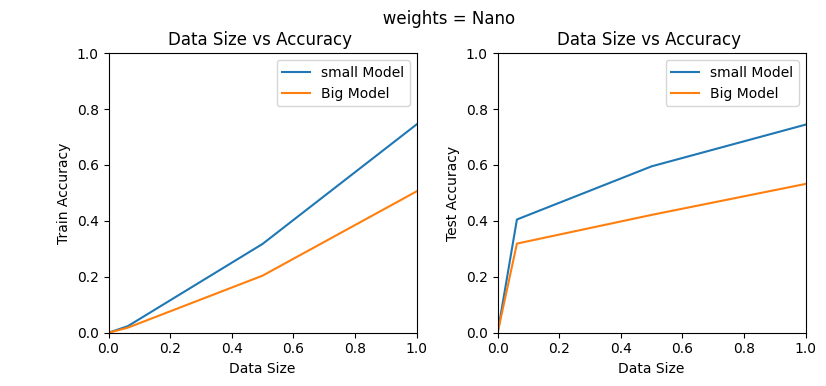

In [ ]:
#=====================================================================
#                             Matplotlib 
#=====================================================================
###########################################
################   none   #################
###########################################
plt.subplots_adjust(hspace=16, wspace=16) 
plt.figure(figsize=(10, 15))
###########################################
################    acc    ################
###########################################
plt.subplot2grid((16,40), (0, 0), rowspan=4, colspan=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
x_ticks = np.arange(0, 1.1, 0.2)
y_ticks = np.arange(0, 1.1, 0.2)
plt.xticks(x_ticks)
plt.xlabel("Data Size")
plt.yticks(y_ticks)
plt.ylabel("Train Accuracy")
plt.title("                                                                       " "weights = Nano\n""Data Size vs Accuracy ")
data_x = [0, 1/16, 0.5, 1]
data_y_small = [0, acc_sixteenth_list_1[epochs-1], acc_half_list_1[epochs-1], acc_all_list_1[epochs-1]]
plt.plot(data_x, data_y_small, label="small Model")
data_y_big = [0, acc_sixteenth_list_3[epochs-1], acc_half_list_3[epochs-1], acc_all_list_3[epochs-1]]
plt.plot(data_x, data_y_big, label="Big Model")
plt.legend()
###########################################
##############    test acc    #############
###########################################
plt.subplot2grid((16,40), (0, 20), rowspan=4, colspan=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
x_ticks = np.arange(0, 1.1, 0.2)
y_ticks = np.arange(0, 1.1, 0.2)
plt.xticks(x_ticks)
plt.xlabel("Data Size")
plt.yticks(y_ticks)
plt.ylabel("Test Accuracy")
plt.title("Data Size vs Accuracy ")
data_x = [0, 1/16, 0.5, 1]
data_y_small = [0, acc_test_sixteenth_list_1[epochs-1], acc_test_half_list_1[epochs-1], acc_test_all_list_1[epochs-1]]
plt.plot(data_x, data_y_small, label="small Model")
data_y_big = [0, acc_test_sixteenth_list_3[epochs-1], acc_test_half_list_3[epochs-1], acc_test_all_list_3[epochs-1]]
plt.plot(data_x, data_y_big, label="Big Model")
plt.legend()



<Figure size 640x480 with 0 Axes>

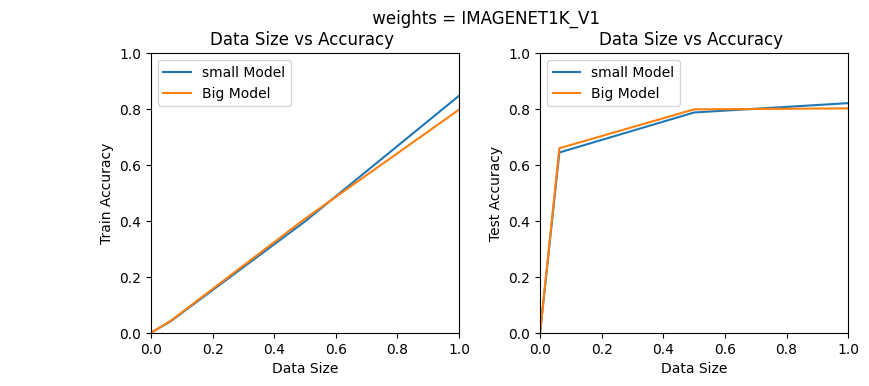

In [ ]:
###########################################
###########    IMAGENET1K_V1   ############
###########################################
plt.subplots_adjust(hspace=16, wspace=16) 
plt.figure(figsize=(10, 15))
###########################################
################    acc   #################
###########################################
plt.subplot2grid((16,40), (0, 0), rowspan=4, colspan=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
x_ticks = np.arange(0, 1.1, 0.2)
y_ticks = np.arange(0, 1.1, 0.2)
plt.xticks(x_ticks)
plt.xlabel("Data Size")
plt.yticks(y_ticks)
plt.ylabel("Train Accuracy")
plt.title("                                                                     " "weights = IMAGENET1K_V1\n""Data Size vs Accuracy ")
data_x = [0, 1/16, 0.5, 1]
data_y_small = [0, acc_sixteenth_list_2[epochs-1], acc_half_list_2[epochs-1], acc_all_list_2[epochs-1]]
plt.plot(data_x, data_y_small, label="small Model")
data_y_big = [0, acc_sixteenth_list_4[epochs-1], acc_half_list_4[epochs-1], acc_all_list_4[epochs-1]]
plt.plot(data_x, data_y_big, label="Big Model")
plt.legend()
###########################################
##############    test acc   ##############
###########################################
plt.subplot2grid((16,40), (0, 20), rowspan=4, colspan=16)
plt.xlim(0, 1)
plt.ylim(0, 1)
x_ticks = np.arange(0, 1.1, 0.2)
y_ticks = np.arange(0, 1.1, 0.2)
plt.xticks(x_ticks)
plt.xlabel("Data Size")
plt.yticks(y_ticks)
plt.ylabel("Test Accuracy")
plt.title("Data Size vs Accuracy ")
data_x = [0, 1/16, 0.5, 1]
data_y_small = [0, acc_test_sixteenth_list_2[epochs-1], acc_test_half_list_2[epochs-1], acc_test_all_list_2[epochs-1]]
plt.plot(data_x, data_y_small, label="small Model")
data_y_big = [0, acc_test_sixteenth_list_4[epochs-1], acc_test_half_list_4[epochs-1], acc_test_all_list_4[epochs-1]]
plt.plot(data_x, data_y_big, label="Big Model")
plt.legend()

## Codes for Problem 3

In [ ]:
# TODO: Try to achieve the best performance given all training data using whatever model and training strategy.
# (New) (You cannot use the model that was pretrained on CIFAR10)

## Problems

1. (30%) Finish the rest of the codes for Problem 1 and Problem 2 according to the hint. (2 code cells in total.)
2. Train small model (resnet18) and big model (resnet50) from scratch on `sixteenth_train_dataloader`, `half_train_dataloader`, and `train_dataloader` respectively.
3. (30%) Achieve the best performance given all training data using whatever model and training strategy.  
  (You cannot use the model that was pretrained on CIFAR10)



## Discussion

Write down your insights in the report. The file name should be report.pdf.
For the following discussion, please present the results graphically as shown in Fig. 1 and discuss them.

- (30%) The relationship between the accuracy, model size, and the training dataset size.  
    (Total 6 models. Small model trains on the sixteenth, half, and all data. Big model trains on the sixteenth, half, and all data. If the result is different from Fig.1, please explain the possible reasons.)
- (10%) What if we train the ResNet with ImageNet initialized weights (`weights="IMAGENET1K_V1"`).
Please explain why the relationship changed this way?

Hint: You can try different hyperparameters combinations when training the models.

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)